In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, re, ENGLISH_STOP_WORDS
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# downloading and saving the HTML content using Selenium
def download_html(driver, file_path):
    time.sleep(5)  # Wait for JavaScript to render
    # save the page source (HTML) to a file
    html_content = driver.page_source
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(html_content)

In [3]:
# extracting reviews
def get_reviews(soup):
    reviews_list = []

    # finding the review elements
    reviews = soup.find_all('div', {'data-hook': 'review'})
    if not reviews:
        print("No reviews found on this page.")
        exit()
        return reviews_list

    for review in reviews:
        try:
            # review title
            title_element = review.find('a', {'data-hook': 'review-title'})
            title = title_element.text.strip().split("\n")[-1] if title_element else 'No title'

            # review body
            body_element = review.find('span', {'data-hook': 'review-body'})
            body = body_element.text.strip() if body_element else 'No body'

            # review rating
            rating_element = review.find('i', {'data-hook': 'review-star-rating'})
            rating = rating_element.text.strip() if rating_element else 'No rating'

            # review date
            date_element = review.find('span', {'data-hook': 'review-date'})
            date = date_element.text.strip() if date_element else 'No date'

            reviews_list.append({
                "title": title,
                "body": body,
                "rating": rating,
                "date": date
            })
        except AttributeError as e:
            print(f"Error parsing review: {e}")
    
    return reviews_list

In [4]:
# main function to scrape reviews, putting it into a data frame
def scrape(asin):
    html_file_path = 'amazon_reviews.html'
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  # 
    driver = webdriver.Chrome(options=options)

    dataframe = pd.DataFrame(columns = ["title", "body", "rating", "date"])
    t = []
    b = []
    r = []
    d = []

    try:
        for page_number in range(1,11):
            url = f'https://www.amazon.com/product-reviews/{asin}/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=' + str(page_number)
            driver.get(url)
            download_html(driver, html_file_path)
            with open(html_file_path, 'r', encoding='utf-8') as file:
                html_content = file.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            reviews = get_reviews(soup)
            if not reviews and page_number == 1:  # if no reviews found on the first page => break the loop
                break
            for review in reviews:
                t.append(review["title"])
                b.append(review["body"])
                r.append(review["rating"])
                d.append(review["date"])

    finally:
        driver.quit()
    
    dataframe["title"] = t
    dataframe["body"] = b
    dataframe["rating"] = r
    dataframe["date"] = d
    return dataframe
    


ani zdaleka nie dokoncene ale pozriem na to neskor :)...

In [3]:
def onlyletters(text):
    no_punc = re.sub(r'[^\w\s]', '',text)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])
    return(no_digits)

In [4]:
# 40000 amazon reviews to train the model
def trainedmodel():
    data = pd.read_csv("40kamazonreviews.csv")
    data["sentiment"] = data["sentiment"].apply(lambda x: int(x))
    data["body"] = data["body"].apply(onlyletters)


    # logistic regression model
    vektor = TfidfVectorizer(max_features = 120)

    # numpy array of features and label (vector of targets)
    Xko = vektor.fit_transform(data.body)
    yko = data["sentiment"]

    # splitting the dataset into training and testing, building the model
    X_train, X_test, y_train, y_test = train_test_split(Xko,yko, test_size= 0.25, random_state=42)
    log_reg = LogisticRegression().fit(X_train,y_train)

    # evaluating the accuracy of the model using the test part of the dataset
    preds = log_reg.predict(X_test)
    accuracy_score(preds,y_test) #0.8516870999240533

    return log_reg


In [26]:
# predicting the sentiment of our reviews

def oursentiment(asin): 
    df = scrape(asin)
    log_reg = trainedmodel()
    vektor = TfidfVectorizer(max_features = 120)

    # cleaning the amazon dataset (rating, stars and sentiment to check the accuracy)
    df["body"] = df["body"].apply(onlyletters)
    df.loc[(df["rating"] == "No rating"), "rating"] = None
    df = df.dropna(subset="rating")
    df["stars"] = df["rating"].apply(lambda x: x.split(".")[0])
    df.loc[(df["stars"] == 3), "stars"] = None 
    df = df.dropna(subset="stars") 
    df["sentiment"] = 0
    df.loc[(df["stars"] == "5") | (df["stars"] == "4"), "sentiment"] = 1 
    df.loc[(df["stars"] == "3"), "sentiment"] = None 
    df = df.dropna(subset="sentiment")
    
    # predicting the sentiment of our reviews with the logistic regression model
    X = vektor.fit_transform(df.body)
    predict = log_reg.predict(X)
    l = [int(i) for i in df["sentiment"]]

    
    print(predict, l, len(predict), len(l))
    print(df)
    print("the accuracy based on stars is:", accuracy_score(predict, l))
    print("number of accurately predicted sentiment:", sum(predict == l), "out of", len(l))
    #print(confusion_matrix([int(i) for i in df["sentiment"]], predict)/len([int(i) for i in df["sentiment"]]))
    return predict

In [27]:
predict = oursentiment()

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1] 73 73
                                                title  \
0                    Comfortable and easy to assemble   
1                    Game changer!! (no pun intended)   
2          It’s actually great. Definitely recommend.   
3                                          Broken Arm   
4   It has it's ups and downs until it doesn't go ...   
..                                                ...   
94                     Fabrics on the armrest ripped.   
96                                    Awesome chair !   
97                broke after a few months **edited**   
98                                    Not recommended  

In [35]:
def sentimentdf(df):
    df["body"] = df["body"].apply(onlyletters)
    df.loc[(df["rating"] == "No rating"), "rating"] = None
    df = df.dropna(subset="rating")
    #df["stars"] = df["rating"].apply(lambda x: x.split(".")[0])
    df.loc[(df["rating"] == 3), "rating"] = None  #stars, "3"
    df = df.dropna(subset="rating") #stars
    df["sentiment"] = 0
    df.loc[(df["rating"] == 5) | (df["rating"] == 4), "sentiment"] = 1 #"5", "4", stars
    df.loc[(df["rating"] == 3), "sentiment"] = None  #"3"
    df = df.dropna(subset="sentiment")
    return df

In [40]:
df = sentimentdf(df)
counterP = 0
counterN = 0
for i in predict:
    if i == 1:
        counterP += 1
    elif i == 0:
        counterN += 1
predictions = pd.DataFrame({"pn":["positive", "negative"], "value": [counterP, counterN]})
l = [int(i) for i in df["sentiment"]]
df["rating"].value_counts()
predictions.head()

,pn,value
0,positive,73
1,negative,0


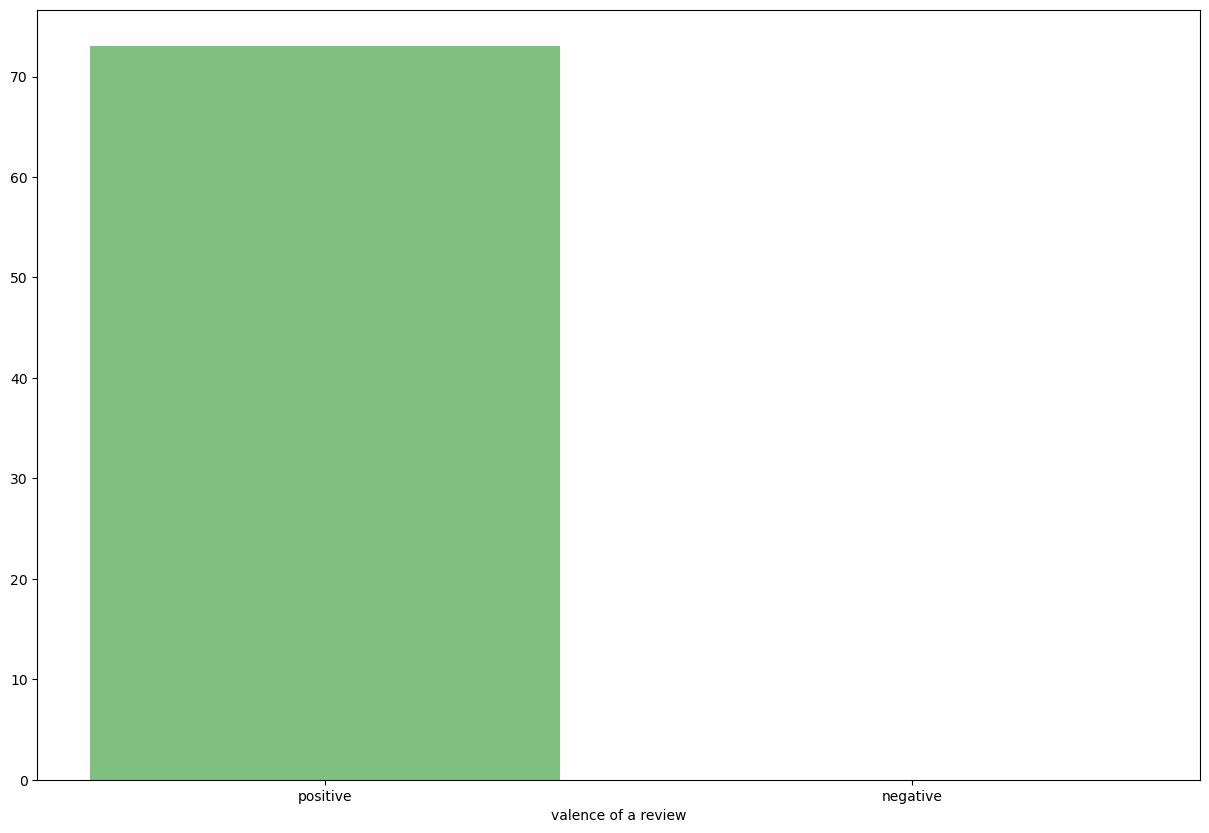

In [32]:
# visualisation
counterP = 0
counterN = 0
for i in predict:
    if i == 1:
        counterP += 1
    elif i == 0:
        counterN += 1
predictions = pd.DataFrame({"pn":["positive", "negative"], "value": [counterP, counterN]})
colors = ["green", "red"]
plt.figure(figsize = (15,10))
plt.bar(predictions["pn"], predictions["value"], color = colors, alpha = 0.5)
plt.xlabel("valence of a review")
colors = ["green", "red"]